# Prerequisites

- Create python virtual environment -> `python -m venv venv`
- Activate the virtual environment -> `. ./venv/scripts/activate`
- Install python requirements in terminal -> `pip install -r requirements.txt`
- Kaggle API key (can be obtained from https://www.kaggle.com). Follow the following instructions: https://github.com/Kaggle/kaggle-api


# Imports


In [1]:
from collections import Counter
import kaggle as kg
import zipfile as zf
import dask.dataframe as df
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf, row_number


import ast
import json


# Download the dataset


In [2]:
# Make sure you have the Kaggle API installed 
kg.api.authenticate()

# Download the movies dataset
kg.api.dataset_download_files('rounakbanik/the-movies-dataset')

# Unzip the dataset
zf.ZipFile('the-movies-dataset.zip').extractall('data')

# Remove the zip file
os.remove('the-movies-dataset.zip')

# Read the data

Set the follwing CSVs as dataframes:

- Movies Dataset: adult, belongs_to_collection, budget, genres, homepage, id, imdb_id, original_language, original_title, overview, popularity, poster_path, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, tagline, title, video, vote_average, vote_count

- Ratings Dataset: userId, movieId, rating, timestamp

- Links Dataset: movieId, imdbId, tmdbId

- Keywords Dataset: id, keywords


In [3]:
# Load the dataset into a Dask dataframe
movies_df = df.read_csv('data/movies_metadata.csv', delimiter=',', header=0, dtype=str)
ratings_df = df.read_csv('data/ratings.csv', delimiter=',', header=0, dtype=str)
links_df = df.read_csv('data/links.csv', delimiter=',', header=0, dtype=str)
keywords_df = df.read_csv('data/keywords.csv', delimiter=',', header=0, dtype=str)


# Print the first 5 rows of each dataframe
print(movies_df.head(5))
print(ratings_df.head(5))
print(links_df.head(5))
print(keywords_df.head(5))

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

# Data Preprocessing

This code segment preprocesses movie, ratings, links, and keywords datasets by selecting relevant columns, handling missing values and data types, and then displays the first five rows of each for verification.


In [4]:
# Preprocessing the Movies Dataset
movies_df = movies_df[['id', 'original_title', 'genres', 'release_date', 'vote_average', 'vote_count']]
movies_df = movies_df.dropna(subset=['original_title', 'genres'])
movies_df['release_date'] = df.to_datetime(movies_df['release_date'], errors='coerce')

# Preprocessing the Ratings Dataset
ratings_df = ratings_df[['userId', 'movieId', 'rating', 'timestamp']]

# Convert data types in Pandas/Dask (if required)
ratings_df['userId'] = ratings_df['userId'].astype(int)
ratings_df['movieId'] = ratings_df['movieId'].astype(int)
ratings_df['rating'] = ratings_df['rating'].astype(float)

# Preprocessing the Links Dataset
links_df = links_df[['movieId', 'imdbId', 'tmdbId']]

# Preprocessing the Keywords Dataset
keywords_df = keywords_df[['id', 'keywords']]

# Print the updated first 5 rows of each dataframe
print(movies_df.head(5))
print(ratings_df.head(5))
print(links_df.head(5))
print(keywords_df.head(5))

      id               original_title  \
0    862                    Toy Story   
1   8844                      Jumanji   
2  15602             Grumpier Old Men   
3  31357            Waiting to Exhale   
4  11862  Father of the Bride Part II   

                                              genres release_date  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   1995-10-30   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   1995-12-15   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   1995-12-22   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   1995-12-22   
4                     [{'id': 35, 'name': 'Comedy'}]   1995-02-10   

  vote_average vote_count  
0          7.7       5415  
1          6.9       2413  
2          6.5         92  
3          6.1         34  
4          5.7        173  
   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     

# Exploratory Data Analysis (EDA)

This code segment visualizes the distribution of movie ratings, the most common movie genres, the distribution of movie release years, and the relationship between average vote and vote count using various plots.


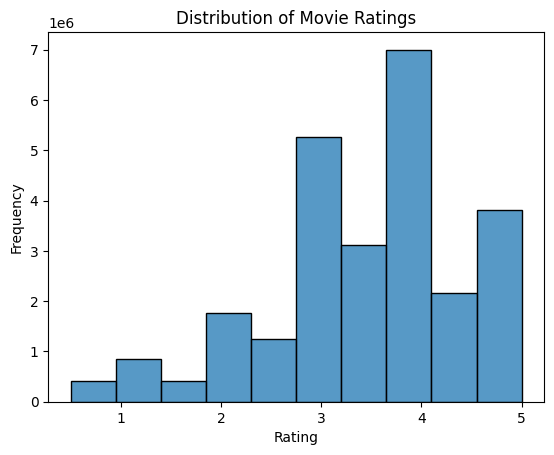

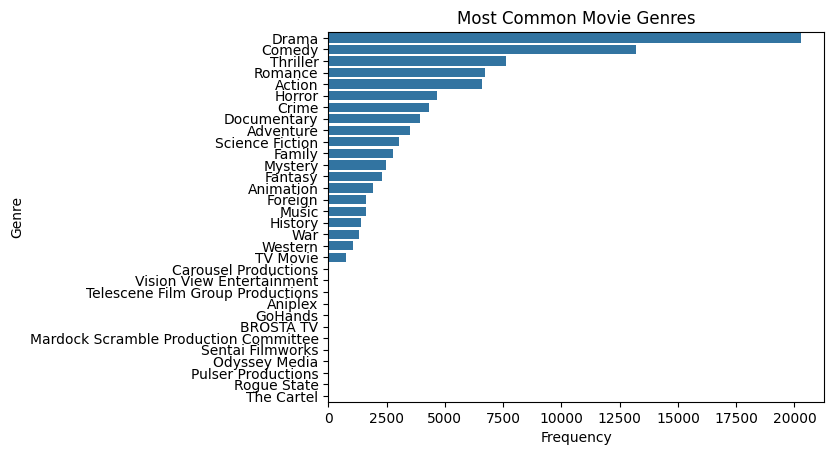

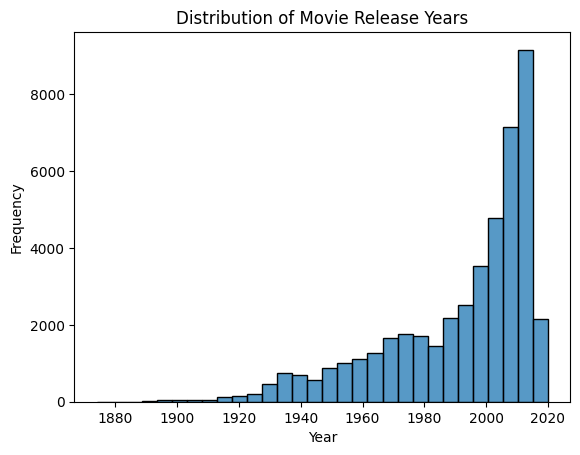

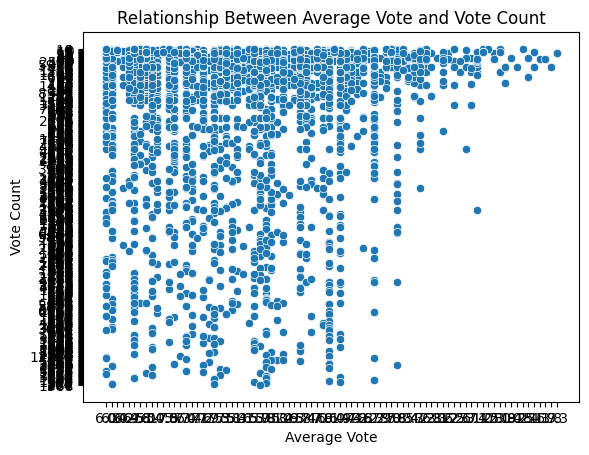

Spearman correlation coefficient: nan
P-value: nan


In [5]:
# Distribution of Movie Ratings
ratings_series = ratings_df['rating'].compute()
sns.histplot(ratings_series, kde=False, bins=10)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Most Common Genres
def extract_genres(genre_str):
    try:
        genres = json.loads(genre_str.replace("'", "\""))
        return [genre['name'] for genre in genres]
    except json.JSONDecodeError:
        return []

# Apply function and count genres
genre_series = movies_df['genres'].apply(extract_genres, meta=('genres', 'object')).compute()

# Flatten the list of lists
flatten_genres = [genre for sublist in genre_series for genre in sublist]

# Count the genres
genre_counts = Counter(flatten_genres)

# Most common genres
common_genres = pd.Series(genre_counts).sort_values(ascending=False)

sns.barplot(x=common_genres.values, y=common_genres.index)
plt.title('Most Common Movie Genres')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.show()

# Release Year Distribution
movies_df['year'] = movies_df['release_date'].dt.year
year_series = movies_df['year'].compute()
sns.histplot(year_series.dropna(), kde=False, bins=30)
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# Relationship Between Rating and Vote Count
sample_movies_df = movies_df.sample(frac=0.1).compute()
sns.scatterplot(data=sample_movies_df, x='vote_average', y='vote_count')
plt.title('Relationship Between Average Vote and Vote Count')
plt.xlabel('Average Vote')
plt.ylabel('Vote Count')
plt.show()

# Calculate Spearman correlation coefficient
correlation, p_value = spearmanr(sample_movies_df['vote_average'], sample_movies_df['vote_count'])

print(f"Spearman correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.2f}")


# Building Collaborative Filtering Model using ALS (Matrix Factorization)

This code sets up a collaborative filtering recommendation system using Spark's ALS algorithm. It initializes a Spark session and converts the ratings data into a Spark DataFrame. Then, it trains the ALS model using the best parameters.


In [6]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Movie Recommendation System") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

# Convert the Dask DataFrame to a Pandas DataFrame
ratings_pandas_df = ratings_df.compute()

# Convert the Pandas DataFrame to a Spark DataFrame
ratings_spark_df = spark.createDataFrame(ratings_pandas_df)

# Check for missing values in the DataFrame
ratings_spark_df = ratings_spark_df.dropna()

# Split the data into training and test sets (80% train, 20% test)
(training_data, test_data) = ratings_spark_df.randomSplit([0.7, 0.3], seed=123)

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Initialize ALS model with default hyperparameters
als_model_baseline = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

# Train ALS model
model_baseline = als_model_baseline.fit(training_data)

# Make predictions
predictions_baseline = model_baseline.transform(test_data)

# Evaluate model
rmse_baseline = evaluator.evaluate(predictions_baseline)

print("RMSE for Baseline Model:", rmse_baseline)

RMSE for Baseline Model: 0.8166829099523997


# Hyptertuning Collaborative Filtering Model

This code sets up a collaborative filtering recommendation system using Spark's ALS algorithm. It initializes a Spark session and converts the ratings data into a Spark DataFrame. Then, it defines a grid of hyperparameters for the ALS model and performs cross-validation to find the best combination of hyperparameters. Finally, it trains the ALS model using the best parameters.


In [10]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Movie Recommendation System") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

print("Spark session started")

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True),
])

# Convert the Dask DataFrame to a Spark DataFrame
ratings_spark_df = spark.createDataFrame(ratings_df.compute(), schema=schema)

print("Spark DataFrame created")

(training, test) = ratings_spark_df.randomSplit([0.8, 0.2])

# ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

print("Model initialized")

# Define a grid of hyperparameters to test
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [12,13,14]) \
    .addGrid(als.maxIter, [18,19,20]) \
    .addGrid(als.regParam, [.17,.18,.19]) \
    .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

print("Hyperparameters defined")

# Validation setup
tvs = TrainValidationSplit(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator)

print("Validation has been setup")

# Fit ALS model to training data
model = tvs.fit(training)

# Extract the best model
bestModel = model.bestModel

print("ALS model trained")

predictions = bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

print(f"Root-mean-square error = {rmse}")
print("Rank:", bestModel.rank)
print("MaxIter:", bestModel._java_obj.parent().getMaxIter())
print("RegParam:", bestModel._java_obj.parent().getRegParam())

Spark session started


ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

# Building Content-Based Filtering Model using TF-IDF

This code initializes a Spark session, converts Dask DataFrames (movies_df and keywords_df) into Spark DataFrames, and merges them based on a common key (id). It then tokenizes the genres and keywords columns and applies TF-IDF to convert them into numerical features.


In [ ]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Movie Recommendation System") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Load the movies dataframe
movies_spark_df = spark.read.csv('data/movies_metadata.csv', header=True)

# Load the keywords dataframe
keywords_spark_df = spark.read.csv('data/keywords.csv', header=True)

# Load the ratings dataframe
ratings_spark_df = spark.read.csv('data/ratings.csv', header=True)

# Preprocessing the Ratings DataFrame
ratings_spark_df = ratings_spark_df.select('userId', 'movieId', 'rating', 'timestamp')
ratings_spark_df = ratings_spark_df.withColumn('timestamp', to_timestamp(col('timestamp')))

# Preprocessing the Movies DataFrame
movies_spark_df = movies_spark_df.select('id', 'original_title', 'genres', 'release_date', 'vote_average', 'vote_count')
movies_spark_df = movies_spark_df.dropna(subset=['original_title', 'genres'])
movies_spark_df = movies_spark_df.withColumn('release_date', to_date(col('release_date'), 'yyyy-MM-dd'))

# Preprocessing the Keywords DataFrame
keywords_spark_df = keywords_spark_df.select('id', 'keywords')
# Merge genres and keywords
movies_spark_df = movies_spark_df.join(keywords_spark_df, movies_spark_df.id == keywords_spark_df.id).select(movies_spark_df["*"], keywords_spark_df["keywords"])

# Tokenize genres and keywords
tokenizer = Tokenizer(inputCol="genres", outputCol="tokenized_genres")
movies_spark_df = tokenizer.transform(movies_spark_df)

tokenizer = Tokenizer(inputCol="keywords", outputCol="tokenized_keywords")
movies_spark_df = tokenizer.transform(movies_spark_df)

# TF-IDF for genres
hashingTF_genres = HashingTF(inputCol="tokenized_genres", outputCol="rawFeatures_genres")
featurizedData_genres = hashingTF_genres.transform(movies_spark_df)

idf_genres = IDF(inputCol="rawFeatures_genres", outputCol="features_genres")
idfModel_genres = idf_genres.fit(featurizedData_genres)
rescaledData_genres = idfModel_genres.transform(featurizedData_genres)

# TF-IDF for keywords
hashingTF_keywords = HashingTF(inputCol="tokenized_keywords", outputCol="rawFeatures_keywords")
featurizedData_keywords = hashingTF_keywords.transform(rescaledData_genres)

idf_keywords = IDF(inputCol="rawFeatures_keywords", outputCol="features_keywords")
idfModel_keywords = idf_keywords.fit(featurizedData_keywords)
rescaledData = idfModel_keywords.transform(featurizedData_keywords)

NameError: name 'to_timestamp' is not defined

# Model Evaluation


In [ ]:
# Generate predictions on test data
predictions = bestModel.transform(test_data)

# Evaluate RMSE
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))

#Evaluate the content-based model

# Join the recommendations with actual ratings
common_elements_df = rescaledData.join(ratings_spark_df, rescaledData.id == ratings_spark_df.movieId)
missing_ids_df = ratings_spark_df.join(rescaledData, ratings_spark_df.movieId == rescaledData.id, 'left_anti')
fn = missing_ids_df.count()
# Calculate recall

tp = common_elements_df.count()
recall = tp / (tp+fn)
print(f"Recall: {recall}")

# Calculate precision
missing_ids_df = rescaledData.join(ratings_spark_df, rescaledData.id == ratings_spark_df.movieId, 'left_anti')
# ratings found in recommendation system but not in ratings.csv
fp = missing_ids_df.count()
tp = common_elements_df.count()
precision = tp / (tp+fp)
print(f"Precision: {precision}")

# calculate the f1-score
f1score = 2*(precision*recall)/(precision+recall)
print(f"f1-score: {f1score}")

Root Mean Squared Error (RMSE) on test data = 0.81


NameError: name 'rescaledData' is not defined

# Comparison and Analysis


In [ ]:
# Compare the performance of both models
# Analyze the strengths and weaknesses


# Visualization and Reporting


In [ ]:
# Visualization code
# Summarize findings, insights, and conclusions